# KDM6A / Kabuki Syndrome 2 

[Kabuki 2 Syndrome - OMIM:300867](https://www.omim.org/entry/300867) is a congenital mental retardation syndrome with additional features, including postnatal dwarfism, a peculiar facies characterized by long palpebral fissures with eversion of the lateral third of the lower eyelids (reminiscent of the make-up of actors of Kabuki, a Japanese traditional theatrical form), a broad and depressed nasal tip, large prominent earlobes, a cleft or high-arched palate, scoliosis, short fifth finger, persistence of fingerpads, radiographic abnormalities of the vertebrae, hands, and hip joints, and recurrent otitis media in infancy


#### **Published Genotype Phenotype Correlations**

##### KDM6A

- [Faundes et al. (2021)](https://www.omim.org/entry/300867#2) analyzed molecular and clinical data in 80 patients with heterozygous or hemizygous mutations in the KDM6A gene. 
    - Patients with protein-altering variants (PAVs) had shorter birth lengths compared to patients with protein termination variants (PTVs).
    - **Patients with PTVs had more impaired intellectual development (97.6% vs 80%) and a higher frequency of central nervous system anomalies (71.4% vs 28.6%) compared to patients with PAVs, although the difference did not reach statistical significance**
    - Faundes et al. (2021) concluded that **individuals with PTVs overall have a more severe phenotype, and the phenotypes of patients with PAVs are more variable.**
    - **F vs M**: Females were found to be significantly more capable of walking independantly (p=0.001) and had more developed speech (p=0.003). Regaring ID severity, males were found to be significantly more affected by intellectual disability (p=0.021). Females were found to have significantly more behavioural problems (p=0.011) and ectodermal anomalies (p=0.039). 
    
- [Wang et al (2024)](https://link.springer.com/article/10.1186/s12887-024-04562-z) analysed sex-specific diference in phenotype of Kabuki syndrome type 2 patients:
    - Moderate-to-severe intellectual disability (IQ<55) was found to be significantly more presenet in male individuals than female (p=0.003)
    - Congenital heart defect was found to be significantly more present in male individuals than female (p=0.015)


In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


In [2]:
gene_symbol = 'KDM6A'
mane_tx_id = 'NM_001291415.2'
mane_px_id = 'NP_001278344.1' 

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
    
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 81/81 [00:11<00:00,  6.93 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
80,Abnormal facial shape
55,Feeding difficulties
54,Delayed speech and language development
52,Hypotonia
38,Narrow palate
35,Prominent fingertip pads
31,Delayed ability to walk
31,Neonatal hypoglycemia
27,Motor delay
24,Microcephaly


/tmp/ipykernel_71613/904924571.py:16: DeprecationWarning: draw_protein_diagram was deprecated and will be removed in `1.0.0`. Use `draw_protein` instead
  visualizer.draw_protein_diagram(


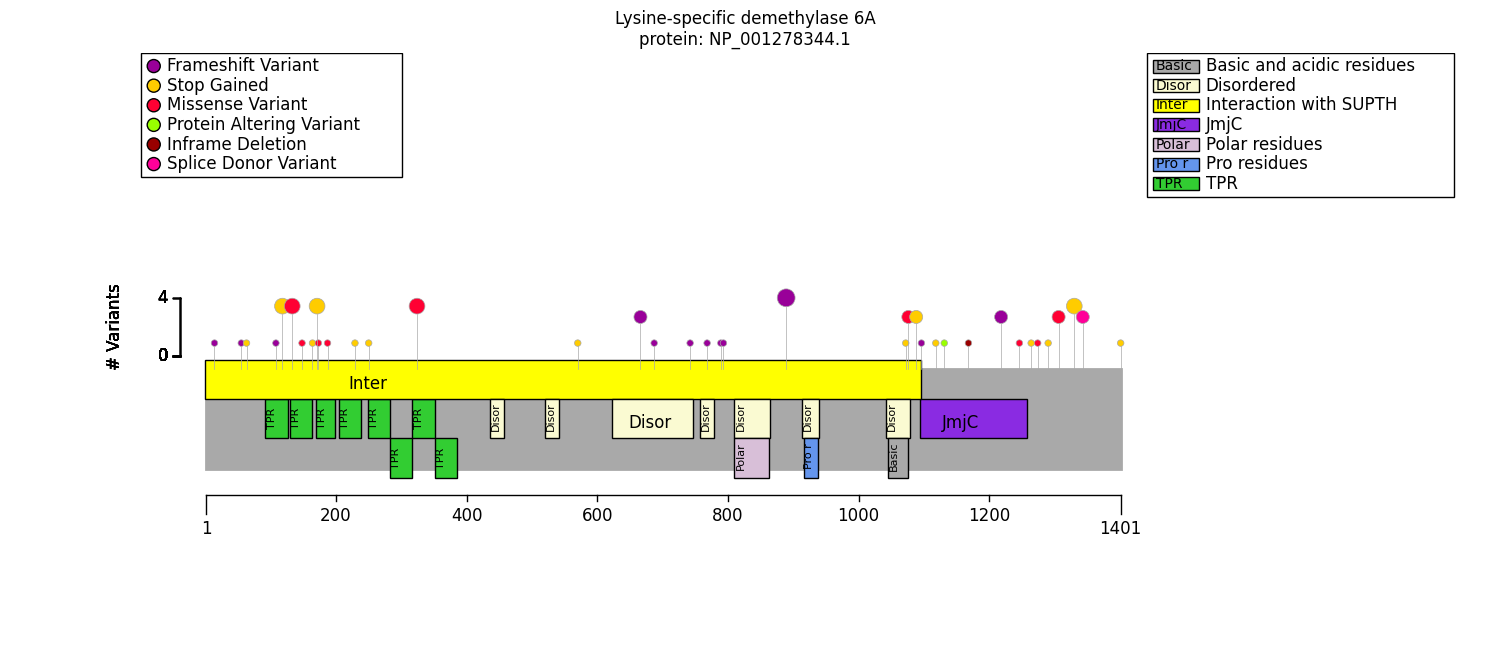

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
from gpsea.model import ProteinMetadata
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)

# protein_meta = pms.annotate(mane_px_id)
# Cannot import via UniProt API at this time. The following code shows how to manually download the information from UniProt, see documentation.
kdm6a_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
protein_meta = ProteinMetadata.from_uniprot_json(protein_id=mane_px_id, uniprot_json="O15550.json", label="Lysine-specific demethylase 6A", protein_length=1401 )
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
kdm6a_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

### Sex differences.

[Faundes et al (2021)](https://pubmed.ncbi.nlm.nih.gov/33674768/) described that Females were found to be significantly more capable of walking independantly (p=0.001), 
males were found to be significantly more affected by intellectual disability (p=0.021), Females were found to have significantly more behavioural problems (p=0.011),
and ectodermal anomalies (p=0.039). [Wang et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/38373926/) described that moderate-to-severe intellectual disability (IQ<55) was found to be significantly more present in male individuals than female (p=0.003). Additionally, Congenital heart defect was found to be significantly more present in male individuals than females (p=0.015).

Wang et al. used HPO terms to analyze the data, but did not apply multiple testing correction. In our dataset,  with the HPO MTC filter used in most other notebooks no associations were found to be significant after multiple testing correction. We show in the following code cell how to test specifically for one term and its descendents if one has a specific hypothesis (in this case, the "frequency of severe intellectual disability is higher in males than in females"). This would be appropriate to test a completely new cohort (in the current case we are reusing data from previously published cases that led to this hypothesis so the analysis is for demonstration purposes only).

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter
from gpsea.analysis.clf import sex_classifier
from gpsea.analysis.pcats import HpoTermAnalysis
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.view import summarize_hpo_analysis

id_curie = "HP:0001249"  # Intellectual disability
id_and_descendants = {id_curie, }
id_and_descendants.update(hpo.graph.get_descendants(id_curie))
# The following command includes Intellectual disability (HP:0001249) and all six of its descendent terms
id_and_descendants_mtc_filter = SpecifiedTermsMtcFilter(
    terms_to_test=id_and_descendants,
)

count_statistic = FisherExactTest()
analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=id_and_descendants_mtc_filter,
)

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
"Intellectual disability, severe [HP:0010864]",7/25 (28%),14/18 (78%),0.007772,0.001943
Intellectual disability [HP:0001249],30/34 (88%),23/23 (100%),0.263237,0.139822
"Intellectual disability, moderate [HP:0002342]",7/25 (28%),2/18 (11%),0.263237,0.263237
"Intellectual disability, mild [HP:0001256]",7/25 (28%),2/18 (11%),0.263237,0.263237


### Mutation Type
In the following we will use the HPO MTC filter to test for associations according to variant type

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier

missense = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, mane_tx_id)
missense_clf =  monoallelic_classifier(a_predicate=missense,
                                      b_predicate=~missense,
                                      a_label="missense",
                                      b_label="other",)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Pulmonic stenosis [HP:0001642],2/10 (20%),0/51 (0%),1.0,0.024590
Microcephaly [HP:0000252],2/8 (25%),22/35 (63%),1.0,0.110923
Cerebral visual impairment [HP:0100704],1/6 (17%),0/29 (0%),1.0,0.171429
Short stature [HP:0004322],2/8 (25%),20/38 (53%),1.0,0.246989
"Intellectual disability, mild [HP:0001256]",0/6 (0%),9/37 (24%),1.0,0.315366
Prominent fingertip pads [HP:0001212],6/9 (67%),29/36 (81%),1.0,0.392932
Patent ductus arteriosus [HP:0001643],1/10 (10%),2/51 (4%),1.0,0.421367
Nystagmus [HP:0000639],1/6 (17%),2/29 (7%),1.0,0.441711
Seizure [HP:0001250],5/10 (50%),12/37 (32%),1.0,0.459735
Intellectual disability [HP:0001249],9/10 (90%),44/47 (94%),1.0,0.548454


In [10]:
ablation = variant_effect(VariantEffect.TRANSCRIPT_ABLATION, tx_id=mane_tx_id) # most common pathogenic allele, n=10
ablation_clf = monoallelic_classifier(a_predicate=ablation,
                                      b_predicate=~ablation,
                                      a_label="SV",
                                      b_label="other",)

ablation_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ablation_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=ablation_result)

Allele group,SV,other,Corrected p values,p values
Prominent fingertip pads [HP:0001212],8/8 (100%),27/37 (73%),1.0,0.168450
Delayed ability to walk [HP:0031936],5/5 (100%),26/36 (72%),1.0,0.310213
Coarctation of aorta [HP:0001680],2/9 (22%),6/52 (12%),1.0,0.335581
Horseshoe kidney [HP:0000085],1/6 (17%),3/44 (7%),1.0,0.410547
Strabismus [HP:0000486],5/8 (62%),11/27 (41%),1.0,0.423602
Ventricular septal defect [HP:0001629],1/9 (11%),4/52 (8%),1.0,0.563137
Delayed speech and language development [HP:0000750],8/9 (89%),46/50 (92%),1.0,0.576789
Bicuspid aortic valve [HP:0001647],0/9 (0%),7/51 (14%),1.0,0.580315
Microcephaly [HP:0000252],3/4 (75%),21/39 (54%),1.0,0.617567
Seizure [HP:0001250],3/6 (50%),14/41 (34%),1.0,0.652894


### Correlation specific Variant 

In [11]:
from gpsea.analysis.predicate import variant_key

del4 = variant_key("X_45070166_45070170_CACAA_C") # c.2671_2674del (p.Asn891ValfsTer27)	

del4_clf = monoallelic_classifier(
    a_predicate=del4,
    b_predicate= ~del4,
    a_label= 'p.Asn891ValfsTer27',
    b_label='Other')

del4_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=del4_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=del4_result)


Allele group,p.Asn891ValfsTer27,Other,Corrected p values,p values
Pulmonic stenosis [HP:0001642],2/2 (100%),0/59 (0%),0.015847,0.000546
Atrial septal defect [HP:0001631],2/2 (100%),14/59 (24%),0.950820,0.065574
Seizure [HP:0001250],2/2 (100%),15/45 (33%),1.000000,0.125809
Ventricular septal defect [HP:0001629],1/2 (50%),4/59 (7%),1.000000,0.158470
Prominent fingertip pads [HP:0001212],2/3 (67%),33/42 (79%),1.000000,0.538760
Left ventricular hypertrophy [HP:0001712],0/2 (0%),1/59 (2%),1.000000,1.000000
Persistent left superior vena cava [HP:0005301],0/2 (0%),1/59 (2%),1.000000,1.000000
Patent ductus arteriosus [HP:0001643],0/2 (0%),3/59 (5%),1.000000,1.000000
Bicuspid aortic valve [HP:0001647],0/2 (0%),7/58 (12%),1.000000,1.000000
Coarctation of aorta [HP:0001680],0/2 (0%),8/59 (14%),1.000000,1.000000


### Summary

-  **M vs F**: significant correlation found regarding severe intellectual disability (corrected p.value: 0.044): Male were found to have more severe intelectual disability

- **Mutation Types** : no significant correlation found

- **Specific Variant**: Significant correlation found for "X_45070166_45070170_CACAA_C" 
for Pulmonic stenosis [HP:0001642] (corrected p.value 0.0049) but to be taken with caution due to low number of instances of the variant.




In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
  GPAnalysisResultSummary.from_multi( result=mf_result,  ),
  GPAnalysisResultSummary.from_multi( result=missense_result,  ),
  GPAnalysisResultSummary.from_multi( result=ablation_result,  ),
  GPAnalysisResultSummary.from_multi( result=del4_result,  ),
)


caption = """."""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_px_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [14]:
summarizer.process_latex(report=report, protein_fig=kdm6a_fig)

Figure saved to ../../supplement/img/KDM6A_protein_diagram-draft.pdf
Output to ../../supplement/tex/KDM6A_summary_draft.tex
